### Add tuning

# Synthetic dataset creation

In this notebook I create a synthetic dataset to test the proposed bandit algorithm and compare it to benchmarks.
Synthetic dataset will have following features:
- 10,000 time points
- At each time $t$ the environment generates a context vector $x_t$ of dimension 6. Each feature $x_t^{(i)}$ is **categorical**, and lies in range(1,feature_size). This is needed for the `state_extract` function in SimOOS to correctly number all the states.
- Each context vector $x_t$ is associated with a cost vector $c_t$. Cost of each feature $c_t^{i}$ follows a Gaussian distribution with fixed standard deviation and **piecewise-constant** mean lying in range $[0; 0.04]$. Change-points of costs are different from change points of rewards.
- A fixed (for all $t$) set $\mathcal{A}$ of 5 arms are available for the algorithm to choose from.
- Rewards associated with each arm and context follow a Bernoulli distribution, parametrized by $p = \sigma(\bar{x_t}^T\theta_{t,a})$. Here $\bar{x_t}$ is not context observed at time t, but rather it is expected context inside one stationarity interval.  Also $\sigma()$ is the sigmoid function and $\theta_{t,a}$ is the ground truth bandit parameter (not disclosed to the algorithm) associated with each arm $a_i$ at time $t$. Bandit parameter satisfies condition $\lVert\theta_{t,a}\rVert_2 \le 1$.  For each arm $a_i$, parameter $\theta_{t,a}$ is piecewise-constant and thus the corresponding **generating process of rewards is piecewise-stationary** with change points every 2000 steps.
This method of generating rewards from contexts follows [1] and [2], but instead of Gaussian reward with mean $x_t^T\theta_{t,a}$ the reward is Bernoulli with parameter $\sigma(\bar{x_t}^T\theta_{t,a})$

[1] Learning Contextual Bandits in a Non-stationary Environment, Wu et al.

[2] Contextual-Bandit Based Personalized Recommendation with Time-Varying User Interests, Xu et al.

In [1]:
import os
os.chdir('../..')
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import time
import math

import costs
from plotting.costs import plot_costs

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)

#### Setting important constants

In [4]:
TIME_POINTS = 10000
NUM_FEATURES = 5
N_ARMS = 5

## Creating context vectors

In [5]:
def categorical(values, distribution, length):
    assert len(values) == len(distribution)
    values = np.array(values)
    sample = np.random.multinomial(1, distribution, size=(length,))
    indices = np.argmax(sample, axis=1)
    return values[indices]

In [6]:
values = [5,6,7,120]
distribution = [0.2, 0.1, 0.4, 0.3]
categorical(values, distribution, length=7)

array([  6,   7, 120,   7,   5,   5,   7])

In [7]:
feature_config = {
    0: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    1: {
        'values': [1, 2],
        'distribution': [0.2, 0.8],
    },
    2: {
        'values': [1, 2, 3],
        'distribution': [ 0.6, 0.3, 0.1],
    },
    3: {
        'values': [1,2,3,4],
        'distribution': [0.1, 0.2, 0.3, 0.4],
    },
    
    4: {
        'values': [1,2,3,4,5],
        'distribution': [0.15, 0.2, 0.3, 0.2, 0.15],
    },
    5: {
        'values': [1,2],
        'distribution': [0.1, 0.9],
    },
    6: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    7: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    8: {
        'values': [1,2,3,4],
        'distribution': [0.4, 0.3, 0.2, 0.1],
    },
    9: {
        'values': [1, 2,3,4,5,6,7,8,9,10,11],
        'distribution': [0.01, 0.03, 0.08, 0.12, 0.16, 0.20, 0.16, 0.12 ,0.08, 0.03, 0.01],
    },
}

In [8]:
contexts = np.zeros((TIME_POINTS, NUM_FEATURES))

for i in range(NUM_FEATURES):
    values = feature_config[i]['values']
    distribution = feature_config[i]['distribution']
    contexts[:, i] = categorical(values, distribution, length=TIME_POINTS)

In [9]:
contexts, contexts.shape

(array([[4., 2., 2., 4., 4.],
        [4., 2., 1., 3., 4.],
        [4., 1., 1., 3., 5.],
        ...,
        [2., 2., 1., 4., 2.],
        [1., 2., 1., 4., 3.],
        [2., 2., 1., 4., 5.]]),
 (10000, 5))

### Visualizing context features

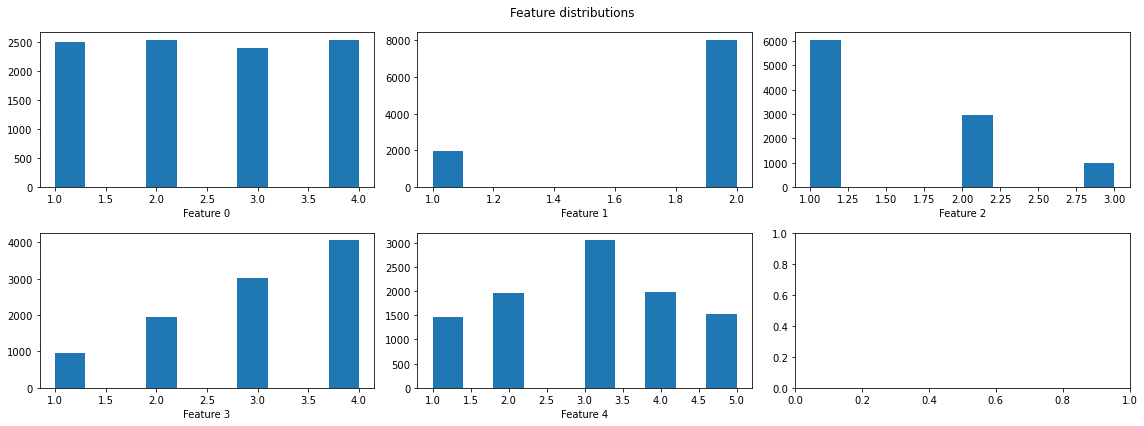

In [10]:
fig, axs = plt.subplots(2, math.ceil(NUM_FEATURES/2), figsize=(16,6))
for i, ax in zip(range(NUM_FEATURES), axs.flatten()):
    ax.hist(contexts[:, i])
    ax.set_xlabel(f"Feature {i}")
fig.suptitle('Feature distributions')
plt.tight_layout()

## Creating cost vectors

In [11]:
# Mean of gaussian distribution random in interval [0, 0.05] 
interval_means = [np.random.uniform(0, 0.02, size=(NUM_FEATURES,)) for i in range(5)]

In [12]:
# Fixed std
interval_stds = [[0.0005]*NUM_FEATURES]*5

In [13]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=NUM_FEATURES,
        change_points=[3000, 4500, 5500, 8000],
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

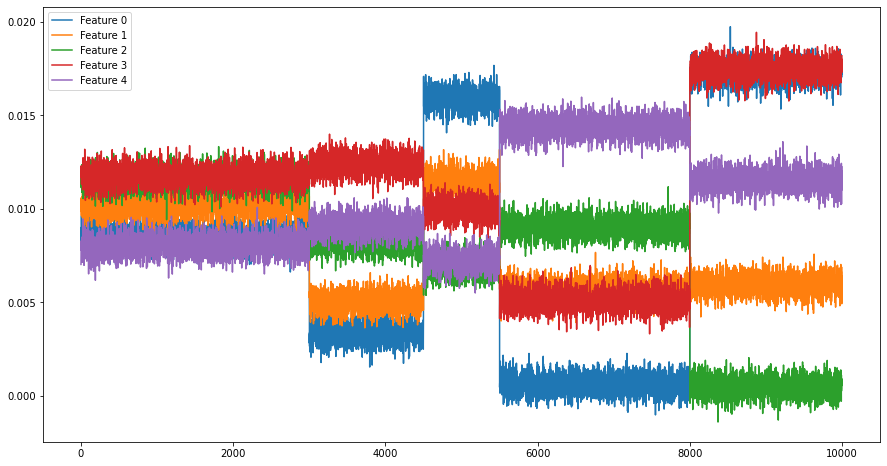

In [14]:
plot_costs(get_costs(), 10000)

In [15]:
costs_obj = get_costs()

In [16]:
costs_vector = []
for t in range(TIME_POINTS):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [17]:
costs_vector.shape

(10000, 5)

## Creating rewards

In [18]:
rewards = np.zeros((TIME_POINTS, N_ARMS))

In [19]:
slices = [
    slice(0,500),
    slice(500,1000),
    slice(1000,2000),
    slice(2000,5000),
    slice(5000,8000),
    slice(8000,10000),
]

In [20]:
HIGH_REWARD_RANGE = [0.4, 0.99]
LOW_REWARD_RANGE = [0.01, 0.4]

In [21]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [22]:
# Here reward is stationary for given slice, arm.
# So piece-wise stationary for a given arm, not depending on context.

mean_rewards = np.zeros(rewards.shape)


for i, interval_slice in enumerate(slices):
    context_slice = contexts[interval_slice, :]
    slice_len = context_slice.shape[0]
    print(f"Slice {i}:")
    high_reward_arm = np.random.choice(N_ARMS)
    
    high_reward_arm = i % N_ARMS
    for arm in range(N_ARMS):

        # Use p from config (reward range is config)
        if arm == high_reward_arm:
            reward_range = HIGH_REWARD_RANGE
        else:
            reward_range = LOW_REWARD_RANGE
        
        p = np.random.uniform(reward_range[0], reward_range[1])

        # Sample rewards from the obtained distribution.
        slice_rewards = np.random.binomial(n=1, p=p, size=(slice_len,))
        rewards[interval_slice, arm] = slice_rewards
        
        # Check that thetas found by linear regression give estimation of expected reward close to
        # true expected reward. 
        
        # thetas found by solving linear regression problem
        linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)
        
        estimated_reward = np.mean(context_slice @ linreg_theta, axis=0)
        
        print(
            f"  Arm {arm}: p={np.mean(p):.2f}, mean reward={np.mean(slice_rewards):.2f}",
            f"  reward estimated by linear regression {estimated_reward:.2f}", 
        )
        
        # for visualization
        mean_rewards[interval_slice, arm] = np.ones(slice_rewards.shape) * np.mean(slice_rewards)

    

Slice 0:
  Arm 0: p=0.48, mean reward=0.49   reward estimated by linear regression 0.48
  Arm 1: p=0.22, mean reward=0.20   reward estimated by linear regression 0.20
  Arm 2: p=0.04, mean reward=0.05   reward estimated by linear regression 0.05
  Arm 3: p=0.35, mean reward=0.31   reward estimated by linear regression 0.30
  Arm 4: p=0.07, mean reward=0.06   reward estimated by linear regression 0.06
Slice 1:
  Arm 0: p=0.24, mean reward=0.26   reward estimated by linear regression 0.25
  Arm 1: p=0.55, mean reward=0.50   reward estimated by linear regression 0.48
  Arm 2: p=0.21, mean reward=0.20   reward estimated by linear regression 0.19
  Arm 3: p=0.27, mean reward=0.28   reward estimated by linear regression 0.27
  Arm 4: p=0.25, mean reward=0.24   reward estimated by linear regression 0.24
Slice 2:
  Arm 0: p=0.02, mean reward=0.02   reward estimated by linear regression 0.02
  Arm 1: p=0.10, mean reward=0.09   reward estimated by linear regression 0.09
  Arm 2: p=0.64, mean rew

/var/folders/_g/d2bwsxss6v9_1830lrh6wyth0000gn/T/ipykernel_54498/492892621.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)


### Visualising rewards

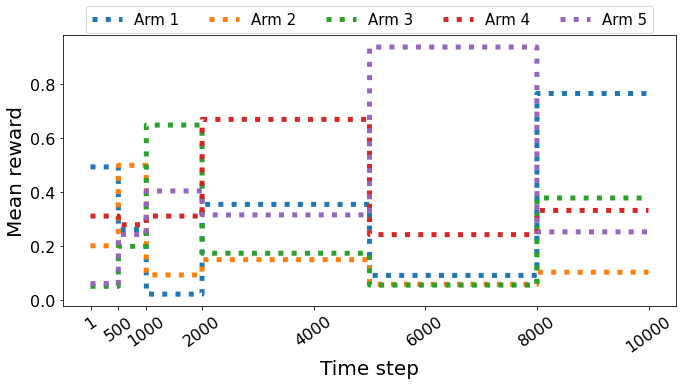

In [23]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(N_ARMS):
    ax.plot(mean_rewards[:, arm], label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    

    
extraticks = [1, 500, 1000]
plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel('Mean reward', fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


In [24]:
rewards.shape

(10000, 5)

In [25]:
costs_vector.shape

(10000, 5)

## Testing algorithms on synthetic data

In [26]:
%load_ext autoreload
%autoreload 2

import algorithms
import evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
NUM_OF_TRIALS = 10000
TUNING_NUM_TRIALS = 2000

### Random policy

#### Evaluation

In [28]:
p_random = algorithms.RandomPolicy()
gain_random = evaluation.evaluate_on_synthetic_data(
    p_random,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

Starting repetition 0:
Random policy
Total gain: 3117.0
	Total reward: 3117.0
	Total cost: 0
Execution time: 0.1s



### $\epsilon$-greedy

#### Tuning

In [29]:
egreedy_gains = {}

for eps in [0.001, 0.005, 0.01, 0.05, 0.08, 0.1, 0.2, 0.3]:
    egreedy = algorithms.EpsilonGreedy(epsilon=eps, n_arms=rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        contexts,
        rewards,
        costs_vector,
        stop_after=TUNING_NUM_TRIALS,
    )
    egreedy_gains[eps] = gain_egreedy

Starting repetition 0:
E-greedy(epsilon=0.001)
Total gain: 396.0
	Total reward: 396.0
	Total cost: 0
Execution time: 0.0s

Starting repetition 0:
E-greedy(epsilon=0.005)
Total gain: 640.0
	Total reward: 640.0
	Total cost: 0
Execution time: 0.0s

Starting repetition 0:
E-greedy(epsilon=0.01)
Total gain: 462.0
	Total reward: 462.0
	Total cost: 0
Execution time: 0.0s

Starting repetition 0:
E-greedy(epsilon=0.05)
Total gain: 703.0
	Total reward: 703.0
	Total cost: 0
Execution time: 0.0s

Starting repetition 0:
E-greedy(epsilon=0.08)
Total gain: 661.0
	Total reward: 661.0
	Total cost: 0
Execution time: 0.0s

Starting repetition 0:
E-greedy(epsilon=0.1)
Total gain: 935.0
	Total reward: 935.0
	Total cost: 0
Execution time: 0.0s

Starting repetition 0:
E-greedy(epsilon=0.2)
Total gain: 853.0
	Total reward: 853.0
	Total cost: 0
Execution time: 0.0s

Starting repetition 0:
E-greedy(epsilon=0.3)
Total gain: 643.0
	Total reward: 643.0
	Total cost: 0
Execution time: 0.0s



In [30]:
last_gains = {k:v[-1] for k,v in egreedy_gains.items()}
best_eps = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]

In [31]:
best_eps

0.1

In [32]:
del egreedy_gains

#### Evaluation

In [33]:
egreedy = algorithms.EpsilonGreedy(epsilon=best_eps, n_arms=rewards.shape[1])

gain_egreedy = evaluation.evaluate_on_synthetic_data(
    egreedy,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

Starting repetition 0:
E-greedy(epsilon=0.1)
Total gain: 3975.0
	Total reward: 3975.0
	Total cost: 0
Execution time: 0.1s



### UCB1

#### Tuning

In [34]:
ucb_gains = {}

for alpha in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    ucb_alg = algorithms.UCB1(
        n_trials=TUNING_NUM_TRIALS,
        n_arms=rewards.shape[1],
        alpha=alpha,
    )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        contexts,
        rewards,
        costs_vector,
        stop_after=TUNING_NUM_TRIALS,
    )
    ucb_gains[alpha] = gain_ucb

Starting repetition 0:
UCB1 (α=0.01)
Total gain: 727.0
	Total reward: 727.0
	Total cost: 0
Execution time: 0.0s

Starting repetition 0:
UCB1 (α=0.05)
Total gain: 908.0
	Total reward: 908.0
	Total cost: 0
Execution time: 0.0s

Starting repetition 0:
UCB1 (α=0.1)
Total gain: 1010.0
	Total reward: 1010.0
	Total cost: 0
Execution time: 0.0s

Starting repetition 0:
UCB1 (α=0.15)
Total gain: 926.0
	Total reward: 926.0
	Total cost: 0
Execution time: 0.0s

Starting repetition 0:
UCB1 (α=0.2)
Total gain: 897.0
	Total reward: 897.0
	Total cost: 0
Execution time: 0.0s

Starting repetition 0:
UCB1 (α=0.25)
Total gain: 1019.0
	Total reward: 1019.0
	Total cost: 0
Execution time: 0.0s

Starting repetition 0:
UCB1 (α=0.3)
Total gain: 1009.0
	Total reward: 1009.0
	Total cost: 0
Execution time: 0.0s

Starting repetition 0:
UCB1 (α=0.35)
Total gain: 1077.0
	Total reward: 1077.0
	Total cost: 0
Execution time: 0.0s

Starting repetition 0:
UCB1 (α=0.4)
Total gain: 1053.0
	Total reward: 1053.0
	Total cost: 0

In [35]:
last_gains = {k:v[-1] for k,v in ucb_gains.items()}
best_alpha_ucb = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]

In [36]:
best_alpha_ucb

0.45

In [37]:
del ucb_gains

#### Evaluation

In [38]:
ucb_alg = algorithms.UCB1(
        n_trials=NUM_OF_TRIALS,
        n_arms=rewards.shape[1],
        alpha=best_alpha_ucb,
    )

gain_ucb = evaluation.evaluate_on_synthetic_data(
    ucb_alg,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

Starting repetition 0:
UCB1 (α=0.45)
Total gain: 5412.0
	Total reward: 5412.0
	Total cost: 0
Execution time: 0.1s



### LinUCB

#### Tuning

In [39]:
linucb_gains = {}

for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    linucb = algorithms.LinUCB(
        n_trials=TUNING_NUM_TRIALS,
        context_dimension=contexts.shape[1],
        n_arms=rewards.shape[1],
        alpha=alpha,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        contexts,
        rewards,
        costs_vector,
        stop_after=TUNING_NUM_TRIALS,
    )
    linucb_gains[alpha] = gain_linucb

Starting repetition 0:
LinUCB (alpha=0.1)
Total gain: 761.858475807685
	Total reward: 862.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
LinUCB (alpha=0.2)
Total gain: 595.8584758076848
	Total reward: 696.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
LinUCB (alpha=0.3)
Total gain: 763.8584758076848
	Total reward: 864.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
LinUCB (alpha=0.4)
Total gain: 642.8584758076846
	Total reward: 743.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
LinUCB (alpha=0.5)
Total gain: 892.8584758076855
	Total reward: 993.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
LinUCB (alpha=0.6)
Total gain: 842.8584758076856
	Total reward: 943.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
LinUCB (alpha=0.7)
Total gain: 853.8584758076857
	Total reward: 954.0
	Total cost: 100.141524192

In [40]:
last_gains = {k:v[-1] for k,v in linucb_gains.items()}
best_alpha_linucb = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]

In [41]:
best_alpha_linucb

0.5

In [42]:
del linucb_gains

#### Evaluation

In [43]:
linucb = algorithms.LinUCB(
    n_trials=NUM_OF_TRIALS,
    context_dimension=contexts.shape[1],
    n_arms=rewards.shape[1],
    alpha=best_alpha_linucb,
)
gain_linucb = evaluation.evaluate_on_synthetic_data(
    linucb,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

Starting repetition 0:
LinUCB (alpha=0.5)
Total gain: 3596.97698627547
	Total reward: 4048.0
	Total cost: 451.0230137245356
Execution time: 0.5s



### PS-LinUCB

#### Tuning

In [44]:
ps_linucb_gains = {}

for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    for omega in [100, 150,  250, 500, 750, 1000, 1500, 2000]:
        for delta in [0.001, 0.003, 0.004, 0.005, 0.006, 0.007, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2, ]:
            ps_linucb = algorithms.PSLinUCB(
                n_trials=TUNING_NUM_TRIALS,
                context_dimension=contexts.shape[1],
                n_arms=rewards.shape[1],
                alpha=alpha,
                omega=omega,
                delta=delta,
            )


            gain_pslinucb = evaluation.evaluate_on_synthetic_data(
                ps_linucb,
                contexts,
                rewards,
                costs_vector,
                stop_after=TUNING_NUM_TRIALS,
            )
            
            ps_linucb_gains[(alpha, omega, delta)] = gain_pslinucb

Starting repetition 0:
PSLinUCB (alpha=0.1, omega=100, delta=0.001)
Total gain: 819.8584758076857
	Total reward: 920.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.1, omega=100, delta=0.003)
Total gain: 819.8584758076857
	Total reward: 920.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.1, omega=100, delta=0.004)
Total gain: 819.8584758076857
	Total reward: 920.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.1, omega=100, delta=0.005)
Total gain: 819.8584758076857
	Total reward: 920.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.1, omega=100, delta=0.006)
Total gain: 819.8584758076857
	Total reward: 920.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.1, omega=100, delta=0.007)
Total gain: 819.8584758076857
	Total reward: 920.0
	Total cost: 100

PSLinUCB (alpha=0.1, omega=750, delta=0.004)
Total gain: 761.858475807685
	Total reward: 862.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.1, omega=750, delta=0.005)
Total gain: 761.858475807685
	Total reward: 862.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.1, omega=750, delta=0.006)
Total gain: 761.858475807685
	Total reward: 862.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.1, omega=750, delta=0.007)
Total gain: 761.858475807685
	Total reward: 862.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.1, omega=750, delta=0.01)
Total gain: 761.858475807685
	Total reward: 862.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.1, omega=750, delta=0.03)
Total gain: 761.858475807685
	Total reward: 862.0
	Total cost: 100.14152419231583
Execution time:

PSLinUCB (alpha=0.2, omega=100, delta=0.004)
Total gain: 805.8584758076853
	Total reward: 906.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.2, omega=100, delta=0.005)
Total gain: 805.8584758076853
	Total reward: 906.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.2, omega=100, delta=0.006)
Total gain: 805.8584758076853
	Total reward: 906.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.2, omega=100, delta=0.007)
Total gain: 805.8584758076853
	Total reward: 906.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.2, omega=100, delta=0.01)
Total gain: 805.8584758076853
	Total reward: 906.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.2, omega=100, delta=0.03)
Total gain: 852.8584758076859
	Total reward: 953.0
	Total cost: 100.14152419231583
Execution

PSLinUCB (alpha=0.2, omega=750, delta=0.004)
Total gain: 595.8584758076848
	Total reward: 696.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.2, omega=750, delta=0.005)
Total gain: 595.8584758076848
	Total reward: 696.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.2, omega=750, delta=0.006)
Total gain: 595.8584758076848
	Total reward: 696.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.2, omega=750, delta=0.007)
Total gain: 595.8584758076848
	Total reward: 696.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.2, omega=750, delta=0.01)
Total gain: 595.8584758076848
	Total reward: 696.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.2, omega=750, delta=0.03)
Total gain: 595.8584758076848
	Total reward: 696.0
	Total cost: 100.14152419231583
Execution

PSLinUCB (alpha=0.3, omega=100, delta=0.006)
Total gain: 798.8584758076852
	Total reward: 899.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.3, omega=100, delta=0.007)
Total gain: 851.8584758076857
	Total reward: 952.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.3, omega=100, delta=0.01)
Total gain: 851.8584758076857
	Total reward: 952.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.3, omega=100, delta=0.03)
Total gain: 631.8584758076846
	Total reward: 732.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.3, omega=100, delta=0.05)
Total gain: 831.8584758076855
	Total reward: 932.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.3, omega=100, delta=0.1)
Total gain: 674.8584758076845
	Total reward: 775.0
	Total cost: 100.14152419231583
Execution ti

PSLinUCB (alpha=0.3, omega=750, delta=0.007)
Total gain: 763.8584758076848
	Total reward: 864.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.3, omega=750, delta=0.01)
Total gain: 763.8584758076848
	Total reward: 864.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.3, omega=750, delta=0.03)
Total gain: 763.8584758076848
	Total reward: 864.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.3, omega=750, delta=0.05)
Total gain: 763.8584758076848
	Total reward: 864.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.3, omega=750, delta=0.1)
Total gain: 763.8584758076848
	Total reward: 864.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.3, omega=750, delta=0.15)
Total gain: 763.8584758076848
	Total reward: 864.0
	Total cost: 100.14152419231583
Execution tim

PSLinUCB (alpha=0.4, omega=100, delta=0.007)
Total gain: 886.8584758076855
	Total reward: 987.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.4, omega=100, delta=0.01)
Total gain: 875.8584758076854
	Total reward: 976.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.4, omega=100, delta=0.03)
Total gain: 881.8584758076857
	Total reward: 982.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.4, omega=100, delta=0.05)
Total gain: 849.8584758076854
	Total reward: 950.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.4, omega=100, delta=0.1)
Total gain: 824.8584758076853
	Total reward: 925.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.4, omega=100, delta=0.15)
Total gain: 805.8584758076852
	Total reward: 906.0
	Total cost: 100.14152419231583
Execution tim

PSLinUCB (alpha=0.4, omega=750, delta=0.03)
Total gain: 642.8584758076846
	Total reward: 743.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.4, omega=750, delta=0.05)
Total gain: 642.8584758076846
	Total reward: 743.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.4, omega=750, delta=0.1)
Total gain: 642.8584758076846
	Total reward: 743.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.4, omega=750, delta=0.15)
Total gain: 642.8584758076846
	Total reward: 743.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.4, omega=750, delta=0.2)
Total gain: 642.8584758076846
	Total reward: 743.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.4, omega=1000, delta=0.001)
Total gain: 642.8584758076846
	Total reward: 743.0
	Total cost: 100.14152419231583
Execution tim

PSLinUCB (alpha=0.5, omega=100, delta=0.03)
Total gain: 858.8584758076856
	Total reward: 959.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.5, omega=100, delta=0.05)
Total gain: 852.8584758076855
	Total reward: 953.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.5, omega=100, delta=0.1)
Total gain: 870.8584758076857
	Total reward: 971.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.5, omega=100, delta=0.15)
Total gain: 862.8584758076859
	Total reward: 963.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.5, omega=100, delta=0.2)
Total gain: 835.8584758076857
	Total reward: 936.0
	Total cost: 100.14152419231583
Execution time: 0.2s

Starting repetition 0:
PSLinUCB (alpha=0.5, omega=150, delta=0.001)
Total gain: 862.8584758076857
	Total reward: 963.0
	Total cost: 100.14152419231583
Execution time

PSLinUCB (alpha=0.5, omega=750, delta=0.05)
Total gain: 892.8584758076855
	Total reward: 993.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.5, omega=750, delta=0.1)
Total gain: 892.8584758076855
	Total reward: 993.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.5, omega=750, delta=0.15)
Total gain: 892.8584758076855
	Total reward: 993.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.5, omega=750, delta=0.2)
Total gain: 892.8584758076855
	Total reward: 993.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.5, omega=1000, delta=0.001)
Total gain: 892.8584758076855
	Total reward: 993.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.5, omega=1000, delta=0.003)
Total gain: 892.8584758076855
	Total reward: 993.0
	Total cost: 100.14152419231583
Execution t

PSLinUCB (alpha=0.6, omega=100, delta=0.05)
Total gain: 884.8584758076859
	Total reward: 985.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.6, omega=100, delta=0.1)
Total gain: 859.8584758076856
	Total reward: 960.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.6, omega=100, delta=0.15)
Total gain: 756.858475807685
	Total reward: 857.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.6, omega=100, delta=0.2)
Total gain: 871.8584758076857
	Total reward: 972.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.6, omega=150, delta=0.001)
Total gain: 880.8584758076857
	Total reward: 981.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.6, omega=150, delta=0.003)
Total gain: 880.8584758076857
	Total reward: 981.0
	Total cost: 100.14152419231583
Execution time

PSLinUCB (alpha=0.6, omega=750, delta=0.05)
Total gain: 842.8584758076856
	Total reward: 943.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.6, omega=750, delta=0.1)
Total gain: 842.8584758076856
	Total reward: 943.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.6, omega=750, delta=0.15)
Total gain: 842.8584758076856
	Total reward: 943.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.6, omega=750, delta=0.2)
Total gain: 842.8584758076856
	Total reward: 943.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.6, omega=1000, delta=0.001)
Total gain: 842.8584758076856
	Total reward: 943.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.6, omega=1000, delta=0.003)
Total gain: 842.8584758076856
	Total reward: 943.0
	Total cost: 100.14152419231583
Execution t

PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Total gain: 881.8584758076859
	Total reward: 982.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.7, omega=100, delta=0.1)
Total gain: 902.8584758076855
	Total reward: 1003.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.7, omega=100, delta=0.15)
Total gain: 875.8584758076859
	Total reward: 976.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.7, omega=100, delta=0.2)
Total gain: 892.8584758076854
	Total reward: 993.0
	Total cost: 100.14152419231583
Execution time: 0.2s

Starting repetition 0:
PSLinUCB (alpha=0.7, omega=150, delta=0.001)
Total gain: 832.8584758076856
	Total reward: 933.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.7, omega=150, delta=0.003)
Total gain: 832.8584758076856
	Total reward: 933.0
	Total cost: 100.14152419231583
Execution ti

PSLinUCB (alpha=0.7, omega=750, delta=0.15)
Total gain: 853.8584758076857
	Total reward: 954.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.7, omega=750, delta=0.2)
Total gain: 853.8584758076857
	Total reward: 954.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.7, omega=1000, delta=0.001)
Total gain: 853.8584758076857
	Total reward: 954.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.7, omega=1000, delta=0.003)
Total gain: 853.8584758076857
	Total reward: 954.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.7, omega=1000, delta=0.004)
Total gain: 853.8584758076857
	Total reward: 954.0
	Total cost: 100.14152419231583
Execution time: 0.1s

Starting repetition 0:
PSLinUCB (alpha=0.7, omega=1000, delta=0.005)
Total gain: 853.8584758076857
	Total reward: 954.0
	Total cost: 100.14152419231583
Execut

In [45]:
last_gains = {k:v[-1] for k,v in ps_linucb_gains.items()}
best_alpha_ps_linucb, best_omega_ps_linucb, best_delta_ps_linucb  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]

In [46]:
best_alpha_ps_linucb, best_omega_ps_linucb, best_delta_ps_linucb

(0.7, 100, 0.03)

In [47]:
del ps_linucb_gains

#### Evaluation

In [48]:
ps_linucb = algorithms.PSLinUCB(
    n_trials=NUM_OF_TRIALS,
    context_dimension=contexts.shape[1],
    n_arms=rewards.shape[1],
    alpha=best_alpha_ps_linucb,
    omega=best_omega_ps_linucb,
    delta=best_delta_ps_linucb,
)


gain_pslinucb = evaluation.evaluate_on_synthetic_data(
    ps_linucb,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)
change_points = ps_linucb.change_points

Starting repetition 0:
PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Total gain: 6543.976986275478
	Total reward: 6995.0
	Total cost: 451.0230137245356
Execution time: 0.5s



### SimOOS

#### Tuning

In [49]:
simoos_gains = {}

for beta in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]:
    for delta in [0.005, 0.01, 0.03, 0.05, 0.08, 0.1, 0.2]:
        s = time.time()
        p_simoos = algorithms.SimOOSAlgorithm(
            all_contexts=contexts[:TUNING_NUM_TRIALS], 
            number_of_actions=rewards.shape[1],
            max_no_red_context=contexts.shape[1],
            beta_SimOOS=beta,
            delta_SimOOS=delta,
        )
        print(f"Took {time.time() - s} seconds")

        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            s = time.time()
            gain_simoos = evaluation.evaluate_on_synthetic_data(
                p_simoos,
                contexts[:TUNING_NUM_TRIALS],
                rewards[:TUNING_NUM_TRIALS],
                costs_vector[:TUNING_NUM_TRIALS],
                stop_after=TUNING_NUM_TRIALS,
            )
            print(f"Took {time.time() - s} seconds")

        simoos_gains[(beta, delta)] = gain_simoos

Took 0.0024499893188476562 seconds
Starting repetition 0:
Trial 0, time 2022-04-06 21:53:19.593845
Trial 500, time 2022-04-06 21:53:25.233625
Trial 1000, time 2022-04-06 21:53:34.408784
Trial 1500, time 2022-04-06 21:53:38.320986
SimOOS (beta=0.1, delta=0.005)
Total gain: 682.2652417394551
	Total reward: 695.0
	Total cost: 12.734758260544474
Execution time: 19.7s

Took 19.701101064682007 seconds
Took 0.0019240379333496094 seconds
Starting repetition 0:
Trial 0, time 2022-04-06 21:53:39.295017
Trial 500, time 2022-04-06 21:54:18.860110
Trial 1000, time 2022-04-06 21:54:27.658591
Trial 1500, time 2022-04-06 21:54:33.246608
SimOOS (beta=0.1, delta=0.01)
Total gain: 509.54188663101957
	Total reward: 572.0
	Total cost: 62.45811336897886
Execution time: 57.9s

Took 57.931697845458984 seconds
Took 0.006121158599853516 seconds
Starting repetition 0:
Trial 0, time 2022-04-06 21:54:37.232982
Trial 500, time 2022-04-06 21:55:17.948826
Trial 1000, time 2022-04-06 21:55:26.882981
Trial 1500, time 2

Trial 500, time 2022-04-06 22:22:25.538773
Trial 1000, time 2022-04-06 22:22:37.335432
Trial 1500, time 2022-04-06 22:22:44.679155
SimOOS (beta=0.4, delta=0.005)
Total gain: 508.5418866310197
	Total reward: 571.0
	Total cost: 62.45811336897886
Execution time: 1.3m

Took 76.17112421989441 seconds
Took 0.0029098987579345703 seconds
Starting repetition 0:
Trial 0, time 2022-04-06 22:22:50.363423
Trial 500, time 2022-04-06 22:23:05.047691
Trial 1000, time 2022-04-06 22:23:11.244922
Trial 1500, time 2022-04-06 22:23:16.404336
SimOOS (beta=0.4, delta=0.01)
Total gain: 726.750054061388
	Total reward: 740.0
	Total cost: 13.24994593861155
Execution time: 27.7s

Took 27.655380964279175 seconds
Took 0.009806156158447266 seconds
Starting repetition 0:
Trial 0, time 2022-04-06 22:23:18.029384
Trial 500, time 2022-04-06 22:23:32.935482
Trial 1000, time 2022-04-06 22:23:37.591059
Trial 1500, time 2022-04-06 22:23:41.399914
SimOOS (beta=0.4, delta=0.03)
Total gain: 706.9844603083493
	Total reward: 721

Trial 500, time 2022-04-06 22:43:44.694020
Trial 1000, time 2022-04-06 22:43:56.447075
Trial 1500, time 2022-04-06 22:44:03.791899
SimOOS (beta=0.7, delta=0.005)
Total gain: 512.5418866310196
	Total reward: 575.0
	Total cost: 62.45811336897886
Execution time: 1.3m

Took 75.58622598648071 seconds
Took 0.0040378570556640625 seconds
Starting repetition 0:
Trial 0, time 2022-04-06 22:44:09.496484
Trial 500, time 2022-04-06 22:44:24.205549
Trial 1000, time 2022-04-06 22:44:28.740285
Trial 1500, time 2022-04-06 22:44:32.708405
SimOOS (beta=0.7, delta=0.01)
Total gain: 677.9844603083493
	Total reward: 692.0
	Total cost: 14.015539691650028
Execution time: 26.4s

Took 26.45044779777527 seconds
Took 0.005511283874511719 seconds
Starting repetition 0:
Trial 0, time 2022-04-06 22:44:35.953534
Trial 500, time 2022-04-06 22:44:50.993238
Trial 1000, time 2022-04-06 22:44:55.964455
Trial 1500, time 2022-04-06 22:45:00.012175
SimOOS (beta=0.7, delta=0.03)
Total gain: 709.9844603083493
	Total reward: 72

In [50]:
last_gains = {k:v[-1] for k,v in simoos_gains.items()}
best_beta_simoos, best_delta_simoos  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]

In [51]:
best_beta_simoos, best_delta_simoos

(0.6, 0.1)

In [52]:
del simoos_gains

#### Evaluation

In [53]:
s = time.time()
p_simoos = algorithms.SimOOSAlgorithm(
    all_contexts=contexts, 
    number_of_actions=rewards.shape[1],
    max_no_red_context=contexts.shape[1],
    beta_SimOOS=best_beta_simoos,
    delta_SimOOS=best_delta_simoos,
)
print(f"Took {time.time() - s} seconds")

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_simoos = evaluation.evaluate_on_synthetic_data(
        p_simoos,
        contexts[:NUM_OF_TRIALS],
        rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")


Took 0.009416341781616211 seconds
Starting repetition 0:
Trial 0, time 2022-04-06 23:14:39.948470
Trial 500, time 2022-04-06 23:14:54.797013
Trial 1000, time 2022-04-06 23:15:00.070239
Trial 1500, time 2022-04-06 23:15:04.946099
Trial 2000, time 2022-04-06 23:15:07.172719
Trial 2500, time 2022-04-06 23:15:09.841267
Trial 3000, time 2022-04-06 23:15:11.993915
Trial 3500, time 2022-04-06 23:15:12.797559
Trial 4000, time 2022-04-06 23:15:19.959742
Trial 4500, time 2022-04-06 23:15:21.076349
Trial 5000, time 2022-04-06 23:15:22.086568
Trial 5500, time 2022-04-06 23:15:27.603014
Trial 6000, time 2022-04-06 23:15:28.519434
Trial 6500, time 2022-04-06 23:15:30.035828
Trial 7000, time 2022-04-06 23:15:30.613219
Trial 7500, time 2022-04-06 23:15:31.342337
Trial 8000, time 2022-04-06 23:15:32.340646
Trial 8500, time 2022-04-06 23:15:33.569566
Trial 9000, time 2022-04-06 23:15:34.528586
Trial 9500, time 2022-04-06 23:15:35.569145
SimOOS (beta=0.6, delta=0.1)
Total gain: 3829.072658084632
	Total r

### Algorithm1

#### Tuning

In [54]:
# Tuning of algorithm1 is done separately in script, namely in /scripts/3_evaluate_alg1_on_synthetic.py

In [55]:
# alg1_gains = {}

# for beta in [1.0]:
#     for delta in  [0.1, 0.15]:
#         for window in [100, 500, 1000, 1250]:
#             s = time.time()
#             p_alg1 = algorithms.Algorithm1(
#                 all_contexts=contexts[:TUNING_NUM_TRIALS], 
#                 number_of_actions=rewards.shape[1],
#                 max_no_red_context=contexts.shape[1],
#                 beta=beta,
#                 delta=delta,
#                 window_length=window,
#             )
#             print(f"Took {time.time() - s} seconds")

#             import warnings
#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 s = time.time()
#                 gain_alg1 = evaluation.evaluate_on_synthetic_data(
#                     p_alg1,
#                     contexts[:TUNING_NUM_TRIALS],
#                     rewards[:TUNING_NUM_TRIALS],
#                     costs_vector[:TUNING_NUM_TRIALS],
#                     stop_after=TUNING_NUM_TRIALS,
#                 )
#                 print(f"Took {time.time() - s} seconds")
#             alg1_gains[(beta, delta, window)] = gain_alg1
            

In [56]:
last_gains = {k:v[-1] for k,v in alg1_gains.items()}
best_beta_alg1, best_delta_alg1, best_window_alg1  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]

NameError: name 'alg1_gains' is not defined

In [ ]:
sorted(
    last_gains.items(), key=lambda x: x[1]
)

In [ ]:
best_beta_alg1, best_delta_alg1, best_window_alg1

In [ ]:
del alg1_gains

#### Evaluation

In [ ]:
s = time.time()
p_alg1 = algorithms.Algorithm1(
    all_contexts=contexts, 
    number_of_actions=rewards.shape[1],
    max_no_red_context=contexts.shape[1],
    beta=best_beta_alg1,
    delta=best_delta_alg1,
    window_length=best_window_alg1,
)
print(f"Took {time.time() - s} seconds")

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_alg1 = evaluation.evaluate_on_synthetic_data(
        p_alg1,
        contexts[:NUM_OF_TRIALS],
        rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")


### Plot cumulative gain

In [ ]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(16, 8));
        
    max_vline=0
    
    for label, gain in gain_dict.items():
        ax.plot(gain, label=label)
        max_vline=max(max_vline, max(gain))
    ax.set_xlabel('Trial')
    ax.set_ylabel('Cumulative gain')
    ax.set_title('Evaluation on synthetic data')
    
#     ax.vlines(change_points, 0, max_vline, label='change points', color='pink')

    plt.legend();
    plt.show();

In [ ]:
plot_gains({
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
#     'Algorithm1': gain_alg1,
},
)
